/usr/local/anaconda3/envs/gan-ada/lib/python3.7/site-packages/ipykernel_launcher.py:95: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/anaconda3/envs/gan-ada/lib/python3.7/site-packages/ipykernel_launcher.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore a

precision of failed:  0.9455185430801408
precision of healthy:  0.6829436902966315
tpr:  0.5504900504900505
fpr:  0.031720573821616325
auc:  0.9112908810182266
f1-score:  0.6958496799504439
roc curve: 


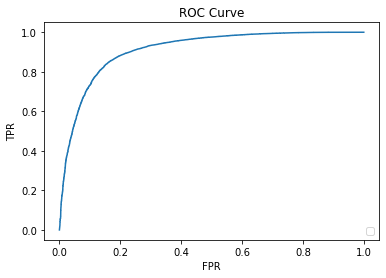

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import metrics
import joblib
import datetime
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from utils.NN import NN, DatasetUtil
import time
from utils import model_and_dataset_selection

n_days_lookahead, data_type, data_folder_name_dict, model_type, model_folder_name_dict = model_and_dataset_selection.metrics_select_offline()

def loadData():

    X = np.load('../../data/' + data_folder_name_dict[data_type] + '/' + str(n_days_lookahead) + '_days_lookahead/smart_test.npy',allow_pickle=True)
    y = np.load('../../data/' + data_folder_name_dict[data_type] + '/' + str(n_days_lookahead) + '_days_lookahead/test_labels.npy', allow_pickle=True)

    X = X.astype('float32')
    y = y.astype('float32')
    return X, y


def get_all_metrics(true, predicted, score):
    confusion_matrix = metrics.confusion_matrix(true, predicted)
    fpr_list, tpr_list, thersholds = roc_curve(true, score)
    roc_auc = auc(fpr_list, tpr_list)
    TP = confusion_matrix[0][0]
    FN = confusion_matrix[0][1]
    FP = confusion_matrix[1][0]
    TN =  confusion_matrix[1][1]
    precision_of_failed = TP / (TP + FP)
    precision_of_healthy = TN / (TN + FN)
    tpr = TP / (TP + FN)
    fpr = FP / (TN + FP)
    auc_score = roc_auc
    f1_score = 2*precision_of_failed*tpr / (precision_of_failed+tpr)
    print('precision of failed: ', precision_of_failed)
    print('precision of healthy: ', precision_of_healthy)
    print('tpr: ', tpr)
    print('fpr: ', fpr)
    print('auc: ', auc_score)
    print('f1-score: ', f1_score)
    print('roc curve: ')
    plt.plot(fpr_list, tpr_list)
    plt.xlim([-0.05, 1.05])  
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
# print('-------------------- NN --------------------')
# print('------------------ Loading Data ------------------')
X, y = loadData()

input_size = 330
hidden_size = 512

output_size = 1
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(device)

model = NN(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
model.load_state_dict(torch.load('../../trained_model/' + model_folder_name_dict[model_type] + '/' + str(n_days_lookahead) + '_days_lookahead/nn.pth'))

X = X.reshape((len(X),-1))

test_dataset = DatasetUtil(X, y)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

y_pred_list = []
y_true_list = []
y_score_list = []
with torch.no_grad():
    total=0
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)
        score = model(X)
        predicted = torch.tensor([1 if x[0] > 0.5 else 0 for x in score]).to(device)
        for j in range(0,len(y)):
            y_pred_list.append(int(predicted[j].cpu()))
            y_true_list.append(y[j].cpu())
            y_score_list.append(float(score[j][0]))

get_all_metrics(np.asarray(y_true_list).astype('int'), np.asarray(y_pred_list), np.asarray(y_score_list))
